In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pymongo import MongoClient
import pydicom as pyd
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
from skimage import measure
import random
from random import shuffle
import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import keras_preprocessing.image as KPImage
from keras.applications.vgg16 import VGG16
from PIL import Image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
client = MongoClient('localhost', 27017)
db = client['rsna-xray']
col = db['patient']

In [3]:
#Getting the next batch of X and y
def next_batch(batchsize, documents, size = (256, 256), 
               classes = ["No Lung Opacity / Not Normal", "Lung Opacity", "Normal"], stacked = False):
    """
    This function is meant to return the image array and the encoded labels for the 
    training of the neural network. 
    
    batchsize - int - how many instances you would want retreived
    
    documents - list - the list of documents you want the batch to come from
    
    size - tuple or list - the size of the output array want
    
    classes - Only change when not using the same three classes, keeps the labels the same
    """
    #randomly shuffles the documents
    idx = np.arange(0, len(documents))
    np.random.shuffle(idx)
    #Getting that number if indices
    idx = idx[:batchsize]
    #Creates a list for that batch
    batch = [documents[i] for i in idx]
    #A numpy matrix of the images
    
    #numpy array for the classes
    y = np.zeros([batchsize, 3])
    #Goes through the batch
    if stacked:
        X = np.zeros([batchsize, size[0], size[1], 3])
        for i, d in enumerate(batch):
            #reads the file
            f = pyd.read_file(d["path"])
            #Inserts the reshaped image in the data frame
            X[i] = resize(image=np.stack([f.pixel_array] * 3, axis=2), output_shape=size)
            #One hot encodes the class
            y[i, classes.index(d["class"])] = 1
    else:
        X = np.zeros([batchsize, size[0], size[1]])
        for i, d in enumerate(batch):
            #reads the file
            f = pyd.read_file(d["path"])
            #Inserts the reshaped image in the data frame
            X[i] = resize(image=f.pixel_array, output_shape=size)
            #One hot encodes the class
            y[i, classes.index(d["class"])] = 1        
    return X, y

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


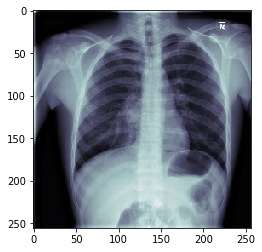

In [9]:
#Testing function
#train_set = list(col.aggregate([{'$sample':{'size':5}}]))
train_set = list(col.find().limit(5))
X, y = next_batch(2, train_set, (256, 256))
plt.imshow(X=X[0], cmap=plt.cm.bone)
plt.show()

In [10]:
print("Number of Normal: {:d}".format(col.count_documents({"class":"Normal"})))
print("Number of Lung Opacity: {:d}".format(col.count_documents({"class":"Lung Opacity"})))
print("Number of No Lung Opacity / Not Normal: {:d}".format(col.count_documents({"class":"No Lung Opacity / Not Normal"})))

Number of Normal: 8851
Number of Lung Opacity: 6012
Number of No Lung Opacity / Not Normal: 11821


In [11]:
normal = list(col.find({"class":"Normal"}))
lung_opacity = list(col.find({"class":"Lung Opacity"}))
not_normal = list(col.find({"class":"No Lung Opacity / Not Normal"}))

In [12]:
np.random.seed(1000)
#Shuffling the documents
np.random.shuffle(normal)
np.random.shuffle(not_normal)
np.random.shuffle(lung_opacity)
#Getting first 4000 of the shuffled list
normal_train = normal[:4000]
opacity_train = lung_opacity[:4000]
not_normal_train = not_normal[:4000]

#getting 4001 to 6000 of each list
normal_test = normal[4000:6000]
opacity_test = lung_opacity[4000:6000]
not_normal_test = not_normal[4000:6000]

#Setting up training and testing list
train = normal_train + not_normal_train + opacity_train
np.random.shuffle(train)
test = normal_test + not_normal_test + opacity_test
np.random.shuffle(test)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


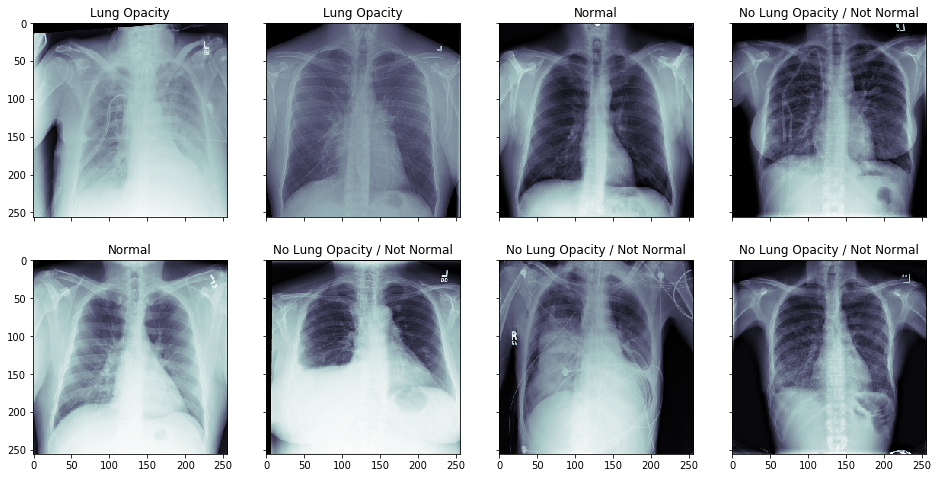

In [13]:
#Showing a batch
X, y = next_batch(8, train, stacked=False)
plt.rcParams["figure.figsize"] = (16, 8)
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
ax = ax.flatten()
for i, (img, label) in enumerate(zip(X, y)):
    ax[i].imshow(img, interpolation='nearest', cmap = plt.cm.bone)
    if np.argmax(label) == 0: ax[i].set_title("No Lung Opacity / Not Normal")
    if np.argmax(label) == 1: ax[i].set_title("Lung Opacity")
    if np.argmax(label) == 2: ax[i].set_title("Normal")


# Custom CNN 

In [73]:
def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def weight_variable(shape):
    initial = tf.truncated_normal(stddev=0.0001, shape=shape)
    return tf.Variable(initial)

def conv_layer(X, w, stride):
    return tf.nn.conv2d(X, w, strides=[1, stride[0], stride[1], stride[2]], padding="SAME")

def pool_layer(X, size, strides):
    return tf.nn.max_pool(X, ksize=[1,size[0], size[1], size[2]], strides=[1,strides[0], strides[1], strides[2]], padding="SAME")

### CNN Architecture

In [120]:
#input
X = tf.placeholder(tf.float32, [None, 256,256])
X_img = tf.reshape(X, [-1, 256,256, 1])
#Convolutional layer 1
W1 = weight_variable([5,5,1,32])
b1 = bias_variable([32])

conv1 = tf.nn.relu(conv_layer(X_img, W1, [2,2,1]) + b1)

#Convolutional Layer 2
W2 = weight_variable([7,7,32,64])
b2 = bias_variable([64])
conv2 = tf.nn.relu(conv_layer(conv1, W2, [2,2,1]) + b2)

#Max Pooling 1
pool1 = pool_layer(conv2, [3,3,1], [1,1,1])

#Convolutional Layer 3
W3 = weight_variable([5,5,64,128])
b3 = bias_variable([128])
conv3 = tf.nn.relu(conv_layer(pool1, W3, [2,2,1]) + b3)

#Convolutional Layer 4
W4 = weight_variable([5,5,128,256])
b4 = bias_variable([256])
conv4 = tf.nn.relu(conv_layer(conv3, W4, [2,2,1]) + b4)

#Max Pooling 2
pool2 = pool_layer(conv4, [3,3,1], [1,1,1])

#Convolutional Layer 5
W5 = weight_variable([3,3,256,512])
b5 = bias_variable([512])
conv5 = tf.nn.relu(conv_layer(pool2, W5, [2,2,1]) + b5)

#Convolutional Layer 6
W6 = weight_variable([3,3,512,1028])
b6 = bias_variable([1028])
conv6 = tf.nn.relu(conv_layer(conv5, W6, [2,2,1]) + b6)

#Max Pooling 3
pool3 = pool_layer(conv6, [2,2,1], [1,1,1])

#Fully Connected 1
W7 = weight_variable([4*4*1028, 2048])
b7 = bias_variable([2048])
flattened = tf.reshape(pool3, shape=[-1, 4*4*1028])
fc1 = tf.nn.relu(tf.matmul(flattened, W7) + b7)

#Dropout 1
#Initializing keep probability for dropout
keep_prob = tf.placeholder(tf.float32)
dropped_fc1 = tf.nn.dropout(fc1, keep_prob)

#Fully Connected 2
W8 = weight_variable([2048, 1024])
b8 = bias_variable([1024])
fc2 = tf.nn.relu(tf.matmul(dropped_fc1, W8) + b8)

#Dropout 2
#Initializing keep probability for dropout
dropped_fc2 = tf.nn.dropout(fc2, keep_prob)

#Fully Connected 3
W9 = weight_variable([1024, 256])
b9 = bias_variable([256])
fc3 = tf.nn.relu(tf.matmul(dropped_fc2, W9) + b9)

#Dropout 3
#Initializing keep probability for dropout
dropped_fc3 = tf.nn.dropout(fc3, keep_prob)

#Fully Connected 4
W10 = weight_variable([256, 3])
b10 = bias_variable([3])
y = tf.nn.softmax(tf.matmul(dropped_fc3, W10) + b10)

y_ = tf.placeholder(tf.float32, [None, 3])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.00005).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [121]:
sess = tf.InteractiveSession()

In [122]:
small_dataset = train[4:8]

In [123]:
tf.global_variables_initializer().run()
for _ in range(1000):
    batch_xs, batch_ys = next_batch(3, small_dataset, stacked=False)
    if _ % 10 == 0:
        train_accuracy = accuracy.eval(feed_dict={X:batch_xs, y_:batch_ys, keep_prob:1.0})
        cost = cross_entropy.eval(feed_dict={X:batch_xs, y_:batch_ys, keep_prob:1.0})
        print("step {:d} training accuracy {:.2f} cost {:.2f}".format(_, train_accuracy, cost))
    sess.run(train_step, feed_dict= {X:batch_xs, y_:batch_ys, keep_prob:0.5})

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


step 0 training accuracy 0.33 cost 1.10
step 10 training accuracy 0.33 cost 1.10
step 20 training accuracy 0.67 cost 1.09
step 30 training accuracy 0.67 cost 0.98
step 40 training accuracy 0.67 cost 0.97
step 50 training accuracy 0.33 cost 1.30
step 60 training accuracy 0.67 cost 0.96
step 70 training accuracy 0.67 cost 0.99
step 80 training accuracy 0.33 cost 1.12
step 90 training accuracy 0.33 cost 1.13
step 100 training accuracy 0.67 cost 0.87
step 110 training accuracy 0.33 cost 1.15
step 120 training accuracy 0.67 cost 0.99
step 130 training accuracy 0.67 cost 0.91
step 140 training accuracy 0.67 cost 0.94
step 150 training accuracy 0.67 cost 0.95
step 160 training accuracy 0.33 cost 1.17
step 170 training accuracy 0.67 cost 0.94
step 180 training accuracy 0.33 cost 1.17
step 190 training accuracy 0.67 cost 0.88
step 200 training accuracy 0.33 cost 1.17
step 210 training accuracy 0.67 cost 0.90
step 220 training accuracy 0.33 cost 1.22
step 230 training accuracy 0.33 cost 1.14
ste

KeyboardInterrupt: 

In [145]:
batch_xs, batch_ys = next_batch(3, small_dataset, stacked=False)
print(y.eval(feed_dict={X:batch_xs, y_:batch_ys, keep_prob:1.0}))
print(batch_ys)
print(accuracy.eval(feed_dict={X:batch_xs, y_:batch_ys, keep_prob:1.0}))

[[0.27886632 0.46499425 0.25613943]
 [0.27886653 0.4649938  0.25613973]
 [0.2788662  0.46499446 0.25613928]]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
0.6666667


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [146]:
sess.close()

# Using VGG16

In [155]:
#Getting the pretained model with the input size of 256, 256, 3
#Not including the dense layers
#Not retraining the CNN Part, only the dense layers
pretrained_VGG16 = VGG16(input_shape =  (256, 256, 3), 
                              include_top = False, weights = 'imagenet')
pretrained_VGG16.trainable = False

In [156]:
#Shape out of the pretrained
pretrained_features = Input(pretrained_VGG16.get_output_shape_at(0)[1:], name = 'feature_input')
#Number of kernels
kernel_depth = pretrained_VGG16.get_output_shape_at(0)[-1]
norm_features = BatchNormalization()(pretrained_features)
global_pooling = GlobalAveragePooling2D()(norm_features)

pooling_dr = Dropout(0.25)(global_pooling)
dr_steps = Dropout(0.25)(Dense(128, activation = 'linear', use_bias=False)(pooling_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(3, activation = 'softmax')(dr_steps)

out_model = Model(inputs = [pretrained_features], 
                   outputs = [out_layer], name = 'trained_model')

out_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65536     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
__________

In [157]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential()
pretrained_VGG16.trainable = False
pneu_model.add(pretrained_VGG16)
pneu_model.add(out_model)
pneu_model.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
trained_model (Model)        (None, 3)                 68483     
Total params: 14,783,171
Trainable params: 67,203
Non-trainable params: 14,715,968
_________________________________________________________________


In [154]:
#Testing to see if it would fit small dataset
"""for _ in np.arange(1000):
    batch_xs, batch_ys = next_batch(3, small_dataset, stacked=True)
    pneu_model.fit(batch_xs, batch_ys)"""

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/1
3/3 [==============================] - 3s 863ms/step - loss: 0.8244 - categorical_accuracy: 0.6667
Epoch 1/1
3/3 [==============================] - 1s 230ms/step - loss: 0.5505 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 222ms/step - loss: 0.5363 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 233ms/step - loss: 0.3734 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 224ms/step - loss: 0.3404 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 222ms/step - loss: 0.1917 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 219ms/step - loss: 0.2501 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 221ms/step - loss: 0.1247 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 230ms/step - loss: 0.1020 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [====

Epoch 1/1
3/3 [==============================] - 1s 240ms/step - loss: 0.0172 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 226ms/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 229ms/step - loss: 0.0138 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 233ms/step - loss: 0.0102 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 231ms/step - loss: 0.0252 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 228ms/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 230ms/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 231ms/step - loss: 0.0087 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 227ms/step - loss: 0.0097 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [====

Epoch 1/1
3/3 [==============================] - 1s 233ms/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 240ms/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 239ms/step - loss: 0.0025 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 246ms/step - loss: 0.0043 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 243ms/step - loss: 0.0034 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 236ms/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 246ms/step - loss: 0.0071 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 243ms/step - loss: 0.0095 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [==============================] - 1s 234ms/step - loss: 0.0203 - categorical_accuracy: 1.0000
Epoch 1/1
3/3 [====

KeyboardInterrupt: 

In [159]:
for _ in np.arange(10000):
    batch_xs, batch_ys = next_batch(24, train, stacked=True)
    pneu_model.fit(batch_xs, batch_ys)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 1.1431 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 199ms/step - loss: 1.0598 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 202ms/step - loss: 0.9374 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 202ms/step - loss: 0.8178 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 202ms/step - loss: 0.8866 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 202ms/step - loss: 0.8646 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.9024 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 0.9236 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 0.7760 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 222ms/step - loss: 0.9897 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 226ms/step - loss: 0.8637 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 220ms/step - loss: 1.0707 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 1.1072 - categorical_accuracy: 0.3750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9360 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9740 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0097 - categorical_accuracy: 0.3333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.2183 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6940 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7346 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6806 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5727 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7636 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7987 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8466 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7093 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5740 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8811 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8534 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7429 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9198 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8933 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 1.0433 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7750 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6355 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8408 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7609 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8171 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8845 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8337 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7412 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6895 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6668 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9060 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8234 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8228 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6960 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7245 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9775 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.1518 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7707 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8194 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8175 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6603 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6131 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7702 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6121 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6099 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8599 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8173 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.0343 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5678 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.0308 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7192 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8333 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.6908 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9380 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7392 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6080 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8952 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.0893 - categorical_accuracy: 0.4167
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5923 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 1.1495 - categorical_accuracy: 0.3333
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6969 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9567 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7774 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5116 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7146 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.0389 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8625 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 1.0065 - categorical_accuracy: 0.4167
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.8243 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8520 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7908 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5951 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7189 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6265 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.5639 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.7835 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7730 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7764 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9393 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6722 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6686 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6297 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8165 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.0308 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7062 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8361 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5980 - categorical_accuracy: 0.8333
E

Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7833 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6908 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7240 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6630 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8713 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7582 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7803 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 1.0183 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.7815 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 0.7968 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9293 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8186 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7537 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7536 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7847 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8609 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8321 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.8563 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5457 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8650 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9162 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.9779 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7334 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7059 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 1.1574 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7726 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 1.0011 - categorical_accuracy: 0.4167
E

Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7269 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7424 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.6368 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.8644 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7631 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.8213 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.7655 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6561 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8376 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7004 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9761 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8772 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5866 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6597 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6879 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8585 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7114 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9120 - categorical_accuracy: 0.5000
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.2717 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6952 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7384 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8947 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6745 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9411 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5683 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7173 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7900 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8861 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6755 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9656 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.5623 - categorical_accuracy: 0.9167
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6250 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 0.8438 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 223ms/step - loss: 0.8148 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 220ms/step - loss: 0.6318 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6337 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5790 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5505 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8725 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8232 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5952 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9930 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9248 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9633 - categorical_accuracy: 0.3333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7775 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9097 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8828 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6750 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6978 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 219ms/step - loss: 0.7933 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.6186 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7891 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7857 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 224ms/step - loss: 0.7842 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6653 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6936 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5688 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6434 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9543 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7895 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9536 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7263 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8047 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6520 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6318 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 217ms/step - loss: 0.5877 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7195 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7437 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7860 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.0146 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6884 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4727 - categorical_accuracy: 0.8333
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7211 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7406 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8513 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6342 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7222 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6234 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5770 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9388 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7370 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6939 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6033 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7196 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6460 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9351 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8857 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7666 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.6936 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8214 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6997 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7074 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5220 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7760 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8281 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.0783 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7996 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7434 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8626 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 1.0291 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6944 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8006 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6118 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7585 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7088 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.1103 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5934 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6310 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9746 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9309 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7111 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9058 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7808 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8114 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7882 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8991 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8512 - categorical_accuracy: 0.4583
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7159 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7526 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9280 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7279 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6051 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8566 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6947 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 219ms/step - loss: 0.6554 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.9925 - categorical_accuracy: 0.3333
E

Epoch 1/1
24/24 [==============================] - 5s 215ms/step - loss: 0.8181 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 218ms/step - loss: 0.9435 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9355 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5466 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7470 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8225 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9787 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5819 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7517 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8765 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6176 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.5923 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.7370 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6067 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7698 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 226ms/step - loss: 1.1084 - categorical_accuracy: 0.2917
Epoch 1/1
24/24 [==============================] - 5s 219ms/step - loss: 0.5669 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.8939 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9532 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8153 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7897 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5105 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8037 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7269 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6873 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8920 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8579 - categorical_accuracy: 0.4583
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8882 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8944 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7508 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7804 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7107 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.1114 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9472 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6669 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7340 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6678 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5604 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7079 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7109 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7264 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7552 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7393 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.1679 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6035 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8383 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8187 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7684 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6576 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8010 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7784 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8940 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8854 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9697 - categorical_accuracy: 0.4583
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7267 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0632 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7313 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9668 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7569 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8825 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6754 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7947 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9647 - categorical_accuracy: 0.4167
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.4828 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7972 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8679 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0093 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7486 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6796 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7196 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6821 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8054 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 215ms/step - loss: 0.6005 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 221ms/step - loss: 0.7308 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 219ms/step - loss: 0.6408 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8703 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7401 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6186 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9976 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6891 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6414 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6874 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7055 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8855 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7612 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6873 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5651 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.5588 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7295 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9841 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.5824 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8380 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6648 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5851 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8179 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7362 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6578 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8686 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7634 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5783 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7649 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7393 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6033 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 220ms/step - loss: 0.9599 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6581 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6345 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9853 - categorical_accuracy: 0.3750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8302 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6124 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0583 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8534 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7007 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7605 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7294 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7995 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6725 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0117 - categorical_accuracy: 0.4583
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8385 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0489 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5666 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8391 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7494 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6425 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5126 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 221ms/step - loss: 0.6638 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8837 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6854 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6253 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8586 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6379 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9245 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6563 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8815 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7339 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8685 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8670 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6406 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.2175 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5059 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7353 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7448 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6147 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7995 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7650 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5728 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5697 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6857 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7986 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.7919 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8946 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6796 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8343 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6188 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6767 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7971 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7527 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7130 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7981 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5466 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8749 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7728 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 218ms/step - loss: 0.7249 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6477 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9606 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9564 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9051 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8203 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.5928 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8507 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7745 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6520 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6988 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8976 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.7805 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6569 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7113 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4887 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9434 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8869 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5899 - categorical_accuracy: 0.8333
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9181 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7709 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7649 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6478 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7004 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4939 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6907 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9494 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6460 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7551 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6523 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6995 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6303 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6945 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6808 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6858 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9270 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7529 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5825 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5870 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.0562 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7418 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6605 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6691 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.9177 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6572 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9698 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8214 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5463 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9925 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9152 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5287 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7040 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6283 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6372 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7034 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8303 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5509 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5988 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4717 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7990 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9031 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7788 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6262 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7298 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6728 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5219 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.1514 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8638 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9086 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6406 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6010 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7304 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6893 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9343 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6875 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8103 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7742 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8314 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8329 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 1.0076 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.9667 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7833 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.6949 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7648 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8051 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6052 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9539 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.8926 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8955 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7824 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9708 - categorical_accuracy: 0.5000
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8812 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7943 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9151 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8617 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8346 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8097 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7572 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7982 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5872 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5603 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.6116 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8062 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0405 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9369 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6990 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7426 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7300 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9399 - categorical_accuracy: 0.5000
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5076 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7091 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.0414 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.6206 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6988 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9211 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9595 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7660 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6065 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7382 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5733 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9513 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8193 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7656 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5403 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6863 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8368 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.6782 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7953 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8186 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9295 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7633 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6348 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6980 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6995 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5816 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5497 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7851 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6234 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7005 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.1561 - categorical_accuracy: 0.4167
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8795 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.7275 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6152 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0491 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5963 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5978 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6462 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7514 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8572 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7542 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9801 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.9775 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.7090 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8433 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8112 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.6697 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6716 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 1.1792 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6852 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7525 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5755 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6298 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6359 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8247 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0057 - categorical_accuracy: 0.3750
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 1.1129 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8927 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6490 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7329 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.8109 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.7347 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8356 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6446 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6166 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.7715 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7032 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9780 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.9649 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.7611 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 203ms/step - loss: 0.8302 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.8237 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7781 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6823 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8032 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6350 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9161 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7958 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6692 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6538 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8455 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5858 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5754 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5894 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.7681 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.8342 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6066 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8749 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8604 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 204ms/step - loss: 0.7281 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9618 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6440 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7269 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5952 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8183 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7532 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7507 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7871 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6180 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7911 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.0035 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.8012 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5661 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4943 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7020 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8583 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5702 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4197 - categorical_accuracy: 0.8750
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5775 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6242 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7754 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6926 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8089 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8324 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7544 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6400 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6750 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5694 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6406 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9300 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7456 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7178 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6401 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7657 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7103 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7717 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9450 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6329 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7366 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6684 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6475 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9655 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9376 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6259 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6816 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.1470 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5233 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9884 - categorical_accuracy: 0.3750
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6051 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8446 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9189 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5511 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6975 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9668 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8032 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8853 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6571 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5273 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6500 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6197 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7299 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6674 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8421 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7018 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4152 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6175 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8402 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6994 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8122 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6859 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7878 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6923 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6944 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8150 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7242 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6350 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7040 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6664 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6450 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5776 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7561 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4918 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8663 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6306 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0957 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7185 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6687 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8008 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5238 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9087 - categorical_accuracy: 0.4583
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7203 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8882 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7992 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8771 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6663 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6594 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6541 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6175 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6447 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7944 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7406 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8714 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.1034 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8156 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.0714 - categorical_accuracy: 0.3333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5084 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5892 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5932 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6350 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7794 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6926 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8817 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4421 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8614 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8537 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6869 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 215ms/step - loss: 0.7548 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7021 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8660 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5919 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7717 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6834 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7461 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6483 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7126 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5447 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8689 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6535 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5312 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6097 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.4321 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7872 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6156 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6362 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4280 - categorical_accuracy: 0.8333
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6660 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9186 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.5812 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8551 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7773 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8219 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6732 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7651 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7156 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7167 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6825 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9635 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5471 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6729 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6893 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 1.2106 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8451 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6716 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5498 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5869 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8800 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6860 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6668 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6373 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7481 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6800 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9486 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7605 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7942 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6480 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5543 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5194 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6333 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8420 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8607 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7525 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7146 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8583 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7858 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6470 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8500 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6215 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5971 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6331 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6459 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5742 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7860 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7815 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6351 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6839 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7679 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7026 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4866 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8225 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6159 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5413 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6109 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7938 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5936 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8714 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7433 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5912 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6952 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4994 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7091 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5201 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7092 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5584 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6519 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7269 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8307 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7045 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7235 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7659 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.6735 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5858 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7349 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7367 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6305 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7504 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7876 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5991 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7082 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8404 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5677 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6305 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7991 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7529 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8217 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7639 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5439 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7196 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8380 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7824 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9275 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8005 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6180 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9726 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6248 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7944 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8340 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6336 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7087 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8294 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8469 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6396 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5575 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7266 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5991 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7396 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.5079 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.1775 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5773 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6050 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6512 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7593 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5631 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6416 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6569 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8705 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6270 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7983 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5339 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8680 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6181 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6687 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7769 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5803 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7164 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6413 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9013 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5603 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7702 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6879 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9771 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8156 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7382 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7617 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7795 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.9165 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5627 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7651 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 216ms/step - loss: 0.9506 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5730 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6342 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5746 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6576 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5267 - categorical_accuracy: 0.9167
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7304 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7507 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7403 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5639 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7659 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.2460 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8671 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6897 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6994 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.0578 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6861 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5621 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7925 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8799 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.7104 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5665 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8853 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8982 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9446 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5395 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7016 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.8095 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5664 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6103 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7275 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8173 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7635 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 221ms/step - loss: 0.6308 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5478 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6419 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6337 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7176 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7038 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5535 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7078 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6044 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6699 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8275 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6583 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9673 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5439 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7002 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6598 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7513 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7724 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6802 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8089 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6194 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5274 - categorical_accuracy: 0.9167
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6417 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6733 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 1.1049 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8392 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7422 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7623 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9819 - categorical_accuracy: 0.3750
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.4078 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8558 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.3833 - categorical_accuracy: 0.3750
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6373 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5810 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 1.0385 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8419 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7079 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5600 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.5092 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5453 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8546 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6636 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7338 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5911 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6000 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.8228 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7545 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6870 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7812 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7565 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7616 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.4881 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7782 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9189 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7153 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6245 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5180 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5552 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5398 - categorical_accuracy: 0.8333
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6566 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7304 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5235 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8121 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7745 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6528 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7451 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5414 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6875 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6161 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6678 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9052 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.0950 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7249 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8348 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7673 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7487 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.9775 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6651 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8209 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5975 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5676 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.6760 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0585 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7586 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.9738 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8942 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8281 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5567 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7076 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7102 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8922 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9048 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5914 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5850 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5844 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6227 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8591 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5273 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7279 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7020 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6770 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8108 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8324 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.4574 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7838 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6102 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6381 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6144 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6874 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8078 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8523 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8976 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8019 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7357 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7187 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9558 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6087 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6223 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8226 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6921 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7707 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7271 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7216 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9815 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 215ms/step - loss: 0.7829 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.4765 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6336 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7366 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.9260 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7417 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5748 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7755 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5655 - categorical_accuracy: 0.9167
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9395 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7031 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7018 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9543 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6834 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6058 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7920 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.7021 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8883 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6061 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 1.0305 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7913 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6979 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6785 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5617 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7548 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9543 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5192 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4992 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6056 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.6076 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8368 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7772 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6822 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7542 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7577 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6574 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7589 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6489 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 205ms/step - loss: 0.9095 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9990 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7812 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7752 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6432 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7680 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7211 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0723 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7736 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8592 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.4768 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8950 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6870 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8213 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8482 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.5172 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.9223 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7409 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6728 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7640 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.6473 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8469 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7318 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7328 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6858 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6430 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6496 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6397 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6965 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8598 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7874 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6724 - categorical_accuracy: 0.7083
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6045 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7048 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.8664 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5042 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 222ms/step - loss: 0.7702 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5263 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7526 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7585 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7236 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6518 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8822 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8522 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8453 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7090 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6014 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7276 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7101 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8395 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5833 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.9399 - categorical_accuracy: 0.4167
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 1.0604 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6017 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6613 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8668 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.6902 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5738 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8028 - categorical_accuracy: 0.6667
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.8094 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4137 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5672 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6996 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 214ms/step - loss: 0.8936 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6432 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6087 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7178 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6155 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.6949 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7704 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6698 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6668 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5288 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6392 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8723 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6261 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.9823 - categorical_accuracy: 0.5417
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.8810 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6872 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7886 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6861 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7409 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8321 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7566 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7761 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7649 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6405 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6083 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.6291 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4345 - categorical_accuracy: 0.9167
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6388 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 212ms/step - loss: 0.6963 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.9405 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5160 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5476 - categorical_accuracy: 0.7917
E

Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6845 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.4838 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7731 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6271 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7147 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8722 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7856 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7866 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.8279 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.4599 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.5204 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6485 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.7576 - categorical_accuracy: 0.5000
Epoch 1/1
24/24 [==============================] - 5s 206ms/step - loss: 0.7266 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5507 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6721 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8334 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8895 - categorical_accuracy: 0.5833
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6898 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6425 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6609 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.6613 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.7500 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.7764 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5082 - categorical_accuracy: 0.7917
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5513 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.8431 - categorical_accuracy: 0.6250
E

Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5793 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.4981 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5386 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.5057 - categorical_accuracy: 0.8750
Epoch 1/1
24/24 [==============================] - 5s 211ms/step - loss: 0.6347 - categorical_accuracy: 0.7083
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6602 - categorical_accuracy: 0.6667
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7765 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 207ms/step - loss: 0.5278 - categorical_accuracy: 0.8333
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5679 - categorical_accuracy: 0.7500
E

Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.6505 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7947 - categorical_accuracy: 0.5417
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.5156 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 213ms/step - loss: 0.9315 - categorical_accuracy: 0.4583
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.5782 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 208ms/step - loss: 0.7164 - categorical_accuracy: 0.6250
Epoch 1/1
24/24 [==============================] - 5s 210ms/step - loss: 0.7410 - categorical_accuracy: 0.5833
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.5649 - categorical_accuracy: 0.7500
Epoch 1/1
24/24 [==============================] - 5s 209ms/step - loss: 0.8172 - categorical_accuracy: 0.6250
E

In [162]:
pneu_model.save_weights('pneumonia_classifier_weights_vgg16.h5')
with open('pneumonia_classifier_weights_vgg16.json', 'w') as f:
    f.write(pneu_model.to_json())